(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [83]:
from nltk.stem.porter import PorterStemmer
import string
import json
import time

p = PorterStemmer()
def stem_word(word):
    return p.stem(word)

def load_lexicon():
    lexicon = dict()
    pos = open('positive-words.txt', 'r').read()[1537:].split('\n') # positive words
    neg = open('negative-words.txt', 'r').read()[1541:].split('\n') # negative words
    for word in pos:
        lexicon[stem_word(word)] = 1
    for word in neg:
        lexicon[stem_word(word)] = -1
    return lexicon

def score_text(text, lexicon):
    # remove all punctuation, make everything lowercase, and split into list by whitespace
    clean = text.lower().translate(string.maketrans("",""), string.punctuation).split()
    score = 0
    for word in [stem_word(x) for x in clean]:
        if word in lexicon: # if stemmed word in lexicon, add value to score
            score += lexicon[word]
    return score

def parse_review_data(filename):
    t = time.clock()
    lexicon = load_lexicon()
    stars = [] # list of review ratings
    scores = [] # list of review scores (to be determined by code)
    review = None # variable for current review in for loop
    n = 0
    for line in open(filename, 'r'):
        if n > 10000:
            break
        n += 1
        review = json.loads(line) # load review from file
        stars.append(review['stars']) # store star rating
        # analyze and store review score
        scores.append(score_text(review['text'].encode('ascii', 'ignore'), lexicon))
    print time.clock() - t
    return stars, scores

def combine_data(stars, scores):
    # dictionary for each star rating
    review_info = [{'total': 0, 'avg': 0, 'min': float('inf'), 'max': float('-inf'), 
                    'pos': 0, 'neg': 0, 'neutral': 0} for i in xrange(5)]
    score = 0
    index = 0
    for i in range(len(stars)): # gather information
        index = stars[i] - 1
        score = scores[i]
        review_info[index]['total'] += 1
        review_info[index]['avg'] += score
        if score > review_info[index]['max']: review_info[index]['max'] = score
        if score < review_info[index]['min']: review_info[index]['min'] = score
        if score > 0: review_info[index]['pos'] += 1
        elif score < 0: review_info[index]['neg'] += 1
        else: review_info[index]['neutral'] += 1
    for i in range(5):
        review_info[i]['avg'] /= float(review_info[i]['total']) # calculate average
    return review_info

filename = 'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json'
stars, scores = parse_review_data(filename)
review_info = combine_data(stars, scores)

11.089601


Visualization and short (detailed) analysis. **(10 pts)**

				  Rating vs. Type of Response


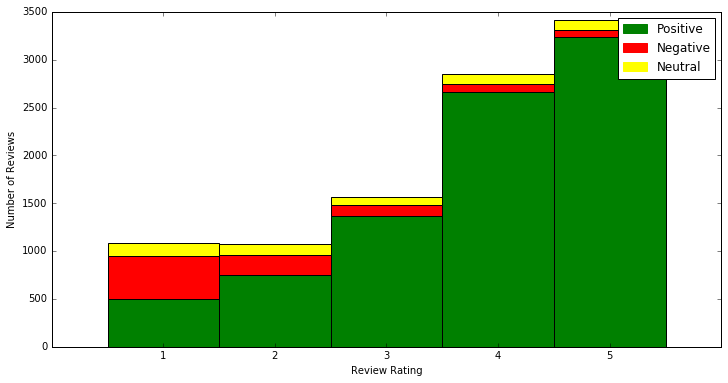

			      Avg, Max and Min Review Per Rating


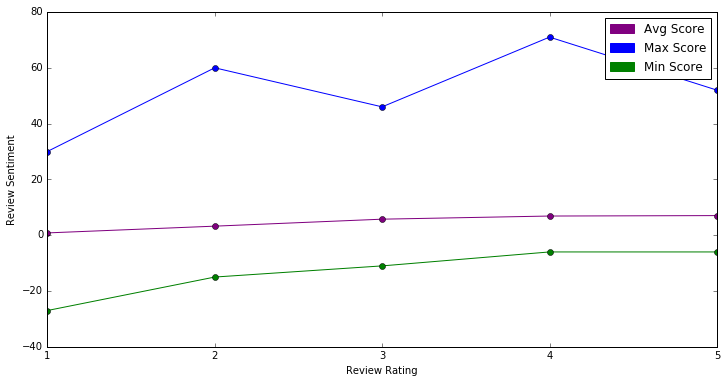

Data For Reviews With 1 Star:
-----------------------------
Total Reviews:        1086
Positive Reviews:     497 (0.46)
Negative Reviews:     448 (0.41)
Neutral Reviews:      141 (0.13)
Max Review Score:     30
Min Review Score:     -27
Average Review Score: 0.82


Data For Reviews With 2 Star:
-----------------------------
Total Reviews:        1073
Positive Reviews:     748 (0.70)
Negative Reviews:     216 (0.20)
Neutral Reviews:      109 (0.10)
Max Review Score:     60
Min Review Score:     -15
Average Review Score: 3.24


Data For Reviews With 3 Star:
-----------------------------
Total Reviews:        1571
Positive Reviews:     1365 (0.87)
Negative Reviews:     119 (0.08)
Neutral Reviews:      87 (0.06)
Max Review Score:     46
Min Review Score:     -11
Average Review Score: 5.74


Data For Reviews With 4 Star:
-----------------------------
Total Reviews:        2853
Positive Reviews:     2667 (0.93)
Negative Reviews:     78 (0.03)
Neutral Reviews:      108 (0.04)
Max Review Score

In [84]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

def print_results(review_info):
    for i in range(5):
        s = 'Data For Reviews With %d Star:\n-----------------------------\n' + \
            'Total Reviews:        %d\nPositive Reviews:     %d (%.2f)\nNegative Reviews:' + \
            '     %d (%.2f)\nNeutral Reviews:      %d (%.2f)\nMax Review Score:     ' + \
            '%d\nMin Review Score:     %d\nAverage Review Score: %.2f\n\n'
        print s % (i+1, 
                   review_info[i]['total'], 
                   review_info[i]['pos'], 
                   float(review_info[i]['pos'])/review_info[i]['total'],
                   review_info[i]['neg'], 
                   float(review_info[i]['neg'])/review_info[i]['total'], 
                   review_info[i]['neutral'], 
                   float(review_info[i]['neutral'])/review_info[i]['total'], 
                   review_info[i]['max'], 
                   review_info[i]['min'], 
                   review_info[i]['avg'])
        
def stacked_bar_graph(x, y_lst, labels, colors, title, xaxis, yaxis):
    xticks = [x[i]-.5 for i in range(len(x))] # so bar graph is in middle of proper number
    delta = [0]*len(x) # account for previous lower level to stack
    keys = [] # legend of graph
    plt.figure(figsize=(12, 6))
    for i in range(len(y_lst)):
        y = y_lst[i]
        plt.bar(xticks, y, 1, bottom=delta, color=colors[i])
        keys += [mpatches.Patch(color=colors[i], label=labels[i])]
        delta = [delta[j]+y[j] for j in range(len(delta))] # add y to lower bottom level
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.legend(handles=keys)
    plt.xticks(x) # so labels remain as they should
    print title # can't get plt.title to work, I think it's a Python 2 thing I'm not used to
    plt.show()
    
def plot_multiple(x, y_lst, labels, colors, title, xaxis, yaxis):
    keys = []
    plt.figure(figsize=(12, 6))
    for i in range(len(y_lst)):
        plt.plot(x, y_lst[i], '-o', color=colors[i])
        keys += [mpatches.Patch(color=colors[i], label=labels[i])]
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.legend(handles=keys)
    plt.xticks(x)
    print title # same title issue as in stacked_bar_graph()
    plt.show()
    
X = list(range(1, 6)) # make x range for plots
avg_scores = [review_info[i]['avg'] for i in range(5)] # list of average scores per rating
max_scores = [review_info[i]['max'] for i in range(5)] # list of max scores per rating
min_scores = [review_info[i]['min'] for i in range(5)] # list of min scores per rating
types = [list(x) for x in zip(*[[review_info[i]['pos'], 
          review_info[i]['neg'], 
          review_info[i]['neutral']] for i in range(5)])] # transpose matrix for stacked bar

stacked_bar_graph(X, types, ['Positive', 'Negative', 'Neutral'], ['green', 'red', 'yellow'], 
                  '\t\t\t\t  Rating vs. Type of Response', 'Review Rating', 
                  'Number of Reviews') # plot 1

plot_multiple(X, [avg_scores, max_scores, min_scores], ['Avg Score', 'Max Score', 'Min Score'],
             ['purple', 'blue', 'green'], '\t\t\t      Avg, Max and Min Review Per Rating', 
             'Review Rating', 'Review Sentiment') # plot 2

print_results(review_info) # print out of all information

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

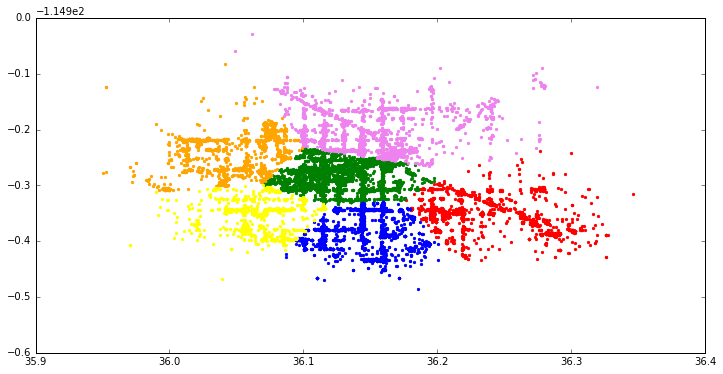

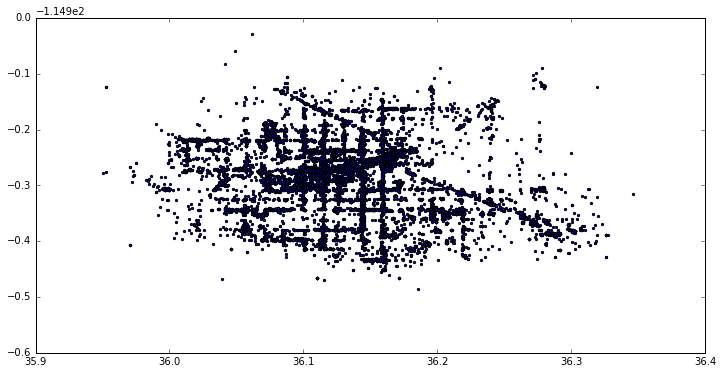

In [90]:
from sklearn.cluster import KMeans
import numpy as np
import json

def parse_business_data(filename):
    lexicon = load_lexicon()
    locations = [] # list of business locations (lat., long.)
    similarities = [] # list of (categories, attributes)
    business = None # variable for current business in for loop
    for line in open(filename, 'r'):
        business = json.loads(line) # load business from file
        if business['city'] == 'Las Vegas' and business['state'] == 'NV':
            locations.append([business['latitude'], business['longitude']])
            similarities.append((business['categories'], business['attributes']))
    return locations, similarities

def cluster(points): # 2d list of [x, y] points
    kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
    kmeans.fit(points)
    return kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_

def plot_cluster(points, labels, colors):
    X = dict()
    for i in range(len(labels)):
        if labels[i] in X:
            X[labels[i]][0].append(points[i][0])
            X[labels[i]][1].append(points[i][1])
        else:
            X[labels[i]] = [[], []]
            X[labels[i]][0].append(points[i][0])
            X[labels[i]][1].append(points[i][1])
    plt.figure(figsize=(12, 6))
    for key in X:
        plt.scatter(X[key][0], X[key][1], color=colors[key], marker=".")
    plt.show()
    

filename = 'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json'
locations, similarities = parse_business_data(filename)
c, l, e = cluster(locations)

plot_cluster(locations, l, ['red', 'green', 'blue', 'violet', 'orange', 'yellow'])

locations = np.array(locations).T

plt.figure(figsize=(12, 6))
plt.scatter(locations[0], locations[1], marker=".")
plt.show()

Visualize your clusters using each technique. Label your clusters. **(10 pts)**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()